<a href="https://colab.research.google.com/github/zhoujiangfeng/mlp/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tensorflow从零开始实现多层感知机
本项目参考李沐大神《动手学习深度学习》
- [多层感知机的从零开始实现-原网页](https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/mlp-scratch.html)
- 唯一区别 没有使用书中提供的d2l库，而是从源代码中截取出来，可能略显复杂，但便于后期修改。

## 1. 导入所需库、定义相关函数

In [200]:
import tensorflow as tf
from IPython import display
from matplotlib_inline import backend_inline
import numpy as np

In [201]:
reshape = tf.reshape
argmax = tf.argmax
astype = tf.cast
reduce_sum = tf.reduce_sum
size = lambda a: tf.size(a).numpy()
numpy = lambda x, *args, **kwargs: x.numpy(*args, **kwargs)

In [202]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签
    Defined in :numref:`sec_fashion_mnist`"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [203]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中
    Defined in :numref:`sec_fashion_mnist`"""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # 将所有数字除以255，使所有像素值介于0和1之间，在最后添加一个批处理维度，
    # 并将标签转换为int32。
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [204]:
def sgd(params, grads, lr, batch_size):
    """小批量随机梯度下降
    Defined in :numref:`sec_linear_scratch`"""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

In [205]:
class Updater():
    """用小批量随机梯度下降法更新参数
    Defined in :numref:`sec_softmax_scratch`"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        sgd(self.params, grads, self.lr, batch_size)

In [206]:
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图
    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

In [207]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [208]:
from matplotlib import pyplot as plt
import sys
model = sys.modules[__name__]
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = model.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [209]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现。
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras的loss默认返回一个批量的平均损失
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [210]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [211]:

def accuracy(y_hat, y):
    """计算预测正确的数量
    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = model.argmax(y_hat, axis=1)
    cmp = model.astype(y_hat, y.dtype) == y
    return float(model.reduce_sum(model.astype(cmp, y.dtype)))

In [212]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度
    Defined in :numref:`sec_softmax_scratch`"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), model.size(y))
    return metric[0] / metric[1]


In [213]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 2. 加载数据集

In [214]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 3.初始化模型参数 
Fashion-MNIst中图像由28*28=78个灰度像素组成，共分为10个类别。 忽略像素之间的空间结构， 我们可以将每个图像视为具有784个输入特征 和10个类的简单分类数据集。 首先，我们将实现一个具有单隐藏层的多层感知机， 它包含256个隐藏单元。 注意，我们可以将这两个变量都视为超参数。 通常，我们选择2的若干次幂作为层的宽度。 因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。 注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。 跟以前一样，我们要为损失关于这些参数的梯度分配内存。

In [215]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
# 初始随机权重
W1 = tf.Variable(tf.random.normal(
    shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
# 初始偏置为0
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(
    shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.zeros(num_outputs))

params = [W1, b1, W2, b2]

## 4.激活函数

In [216]:
def relu(X):
    return tf.math.maximum(X, 0)

## 5. 模型
因为我们忽略了空间结构， 所以我们使用reshape将每个二维图像转换为一个长度为num_inputs的向量。 只需几行代码就可以实现我们的模型。

In [217]:
def net(X):
    X = tf.reshape(X, (-1, num_inputs))
    H = relu(tf.matmul(X, W1) + b1)
    return tf.matmul(H, W2) + b2

## 6. 损失函数

In [218]:
def loss(y_hat, y):
    return tf.losses.sparse_categorical_crossentropy(
        y, y_hat, from_logits=True)

## 7. 训练阶段
迭代周期数设置为10，并将学习率设置为0.1.



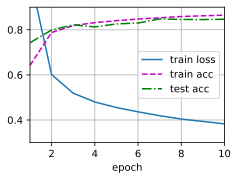

In [219]:
num_epochs, lr = 10, 0.1
updater = Updater([W1, W2, b1, b2], lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

## 8.预测

In [223]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=3):
    """绘制图像列表
    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = model.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(model.numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return 

In [224]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(model.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    model.show_images(
        model.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

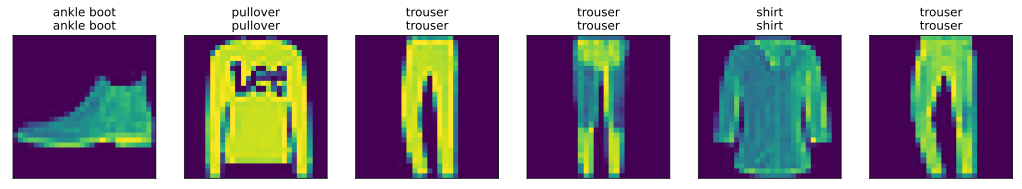

In [225]:
model.predict_ch3(net, test_iter)